### Import the libraries

In [3]:
!pip install "numpy<2.0" --force-reinstall

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4


In [3]:
# reinstall scanpy
!pip install scanpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 43.1 MB/s eta 0:00:00 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 44.1 MB/s eta 0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10/10 [scanpy]━━  9/10 [scanpy]]els]


In [77]:

# standard libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import scanpy as sc
from scipy.sparse import csr_matrix

# Visualize latent space
import matplotlib.pyplot as plt
import seaborn as sns

# add time stamp
import os
from pathlib import Path

from datetime import datetime

# data loader
from torch.utils.data import DataLoader
from tqdm import tqdm


### Change working directory

In [80]:
# go to current directory
%cd /home/ubuntu/anatoly-tahoe-100-texas/code/tahoe-100m

/home/ubuntu/anatoly-tahoe-100-texas/code/tahoe-100m


### Create time stamps

In [83]:

# Create checkpoint directory with timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
checkpoint_dir = f'models'
os.makedirs(checkpoint_dir, exist_ok=True)


### Import the data

In [3]:

adata_100m=sc.read_h5ad("/home/ubuntu/anatoly-tahoe-100-texas/data/tahoe-100m_5M.h5ad")


/home/ubuntu/miniconda3/envs/torch-gpu/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


### Normalize the data

In [4]:

# Normalize each cell to 10,000 counts (CPM-like)
sc.pp.normalize_total(adata_100m, target_sum=1e4)

# Log-transform the data
sc.pp.log1p(adata_100m)


### HVG selection (start with small subset)

In [15]:

# Step 2: Identify highly variable genes
sc.pp.highly_variable_genes(adata_100m, n_top_genes=2000, subset=True, flavor="seurat")


### Train and test data split

In [17]:

# get train and test idx
train_idx, test_idx = train_test_split(adata_100m.obs.index, test_size=0.1, random_state=42)

# data split with copy
adata_train = adata_100m[train_idx].copy()
adata_test = adata_100m[test_idx].copy()

### Dataset class

In [19]:

class AdataCVAEWrapper(Dataset):
    def __init__(self, adata, cat_features, cont_features):
        self.X = adata.X  # keep expression data as sparse matrix
        self.cat_data = pd.get_dummies(adata.obs[cat_features], drop_first=False).values.astype(np.float32)
        self.cat_data = torch.from_numpy(self.cat_data)

        cont = adata.obs[cont_features].values.astype(np.float32)
        cont = (cont - cont.mean(axis=0)) / cont.std(axis=0)
        self.cont_data = torch.from_numpy(cont)

        self.cond = torch.cat([self.cat_data, self.cont_data], dim=1)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x_row = torch.tensor(self.X[idx].toarray().squeeze(), dtype=torch.float32)
        c = self.cond[idx]
        return x_row, c
    

### Neural network class

In [88]:
class CVAE(nn.Module):
    def __init__(self, input_dim, cond_dim, latent_dim=20):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + cond_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + cond_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.ReLU()  # or identity / Sigmoid depending on your output
        )

    def encode(self, x, c):
        h = self.encoder(torch.cat([x, c], dim=1))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        return self.decoder(torch.cat([z, c], dim=1))

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, c)
        return recon_x, mu, logvar

### Loss function

In [89]:
def loss_function(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

### Prepare the data

In [90]:

# setup features
cat_features=["drug", "cell_line_id"]
cont_features=["drug_conc"]

# create train and test datasets
train_dataset = AdataCVAEWrapper(adata_train, cat_features, cont_features)
test_dataset = AdataCVAEWrapper(adata_test, cat_features, cont_features)

# create train and test loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)


In [103]:

# setup the model
model = CVAE(input_dim=adata_train.shape[1], cond_dim=train_dataset.cond.shape[1])
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


CVAE(
  (encoder): Sequential(
    (0): Linear(in_features=2146, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
  )
  (fc_mu): Linear(in_features=128, out_features=20, bias=True)
  (fc_logvar): Linear(in_features=128, out_features=20, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=166, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=2000, bias=True)
    (5): ReLU()
  )
)

### Setup parameters and create validation dataset

In [92]:
# Create validation set from training data
train_idx, val_idx = train_test_split(adata_train.obs.index, test_size=0.1, random_state=42)
adata_val = adata_train[val_idx].copy()

# create validation dataset
val_dataset = AdataCVAEWrapper(adata_val, cat_features, cont_features)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)


### Train the model for 100 of epochs

In [98]:
# Save training configuration

n_epochs = 200

# no early stopping
patience = 999

config = {
    'input_dim': adata_train.shape[1],
    'latent_dim': 32,
    'batch_size': 128,
    'learning_rate': 1e-3,
    'n_epochs': n_epochs,
    'patience': patience,
    'timestamp': timestamp
}

with open(f'{checkpoint_dir}/config.txt', 'w') as f:
    for key, value in config.items():
        f.write(f'{key}: {value}\n')

In [99]:
# Training loop
for epoch in range(n_epochs):
    # Training phase
    model.train()
    train_loss = 0
    for x_batch, c_batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{n_epochs}'):
        x_batch = x_batch.to(device)
        c_batch = c_batch.to(device)

        recon_x, mu, logvar = model(x_batch, c_batch)
        loss = loss_function(recon_x, x_batch, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, c_batch in val_loader:
            x_batch = x_batch.to(device)
            c_batch = c_batch.to(device)
            
            recon_x, mu, logvar = model(x_batch, c_batch)
            loss = loss_function(recon_x, x_batch, mu, logvar)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    # Save checkpoint
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(checkpoint, f'{checkpoint_dir}/best_model.pth')
        print(f'New best model saved with validation loss: {best_val_loss:.2f}')
    else:
        patience_counter += 1
    
    # Save latest checkpoint
    torch.save(checkpoint, f'{checkpoint_dir}/latest_model.pth')
    
    print(f'Epoch {epoch+1}/{n_epochs}:')
    print(f'  Train Loss: {avg_train_loss:.2f}')
    print(f'  Val Loss: {avg_val_loss:.2f}')
    print(f'  Best Val Loss: {best_val_loss:.2f}')
    print(f'  Patience Counter: {patience_counter}/{patience}')
    
    # early stopping if patience is reached
    if patience_counter >= patience:
        print(f'Early stopping triggered after {epoch+1} epochs')
        break

Epoch 1/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:50<00:00, 140.50it/s]


Epoch 1/200:
  Train Loss: 28550.10
  Val Loss: 28436.82
  Best Val Loss: 27374.40
  Patience Counter: 3/10


Epoch 2/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:51<00:00, 137.43it/s]


Epoch 2/200:
  Train Loss: 28453.78
  Val Loss: 28377.08
  Best Val Loss: 27374.40
  Patience Counter: 4/10


Epoch 3/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:50<00:00, 138.31it/s]


Epoch 3/200:
  Train Loss: 28403.80
  Val Loss: 28331.81
  Best Val Loss: 27374.40
  Patience Counter: 5/10


Epoch 4/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:51<00:00, 137.70it/s]


Epoch 4/200:
  Train Loss: 28365.44
  Val Loss: 28290.19
  Best Val Loss: 27374.40
  Patience Counter: 6/10


Epoch 5/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:51<00:00, 137.27it/s]


Epoch 5/200:
  Train Loss: 28336.63
  Val Loss: 28083.95
  Best Val Loss: 27374.40
  Patience Counter: 7/10


Epoch 6/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:51<00:00, 137.67it/s]


Epoch 6/200:
  Train Loss: 28097.44
  Val Loss: 28042.20
  Best Val Loss: 27374.40
  Patience Counter: 8/10


Epoch 7/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:50<00:00, 138.31it/s]


Epoch 7/200:
  Train Loss: 28076.16
  Val Loss: 28004.43
  Best Val Loss: 27374.40
  Patience Counter: 9/10


Epoch 8/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7032/7032 [00:50<00:00, 138.63it/s]


Epoch 8/200:
  Train Loss: 28058.97
  Val Loss: 28009.14
  Best Val Loss: 27374.40
  Patience Counter: 10/10
Early stopping triggered after 8 epochs


### Evaluate the model

In [100]:

def evaluate_model(model, test_loader, device):
    model.eval()
    total_loss = 0
    all_recon = []
    all_original = []
    all_latent = []
    all_conditions = []
    
    with torch.no_grad():
        for x_batch, c_batch in tqdm(test_loader):
            x_batch = x_batch.to(device)
            c_batch = c_batch.to(device)
            
            # Forward pass
            recon_x, mu, logvar = model(x_batch, c_batch)
            loss = loss_function(recon_x, x_batch, mu, logvar)
            total_loss += loss.item()
            
            # Store results
            all_recon.append(recon_x.cpu().numpy())
            all_original.append(x_batch.cpu().numpy())
            all_latent.append(mu.cpu().numpy())
            all_conditions.append(c_batch.cpu().numpy())
    
    # Concatenate all batches
    all_recon = np.concatenate(all_recon, axis=0)
    all_original = np.concatenate(all_original, axis=0)
    all_latent = np.concatenate(all_latent, axis=0)
    all_conditions = np.concatenate(all_conditions, axis=0)
    
    return {
        'total_loss': total_loss,
        'recon': all_recon,
        'original': all_original,
        'latent': all_latent,
        'conditions': all_conditions
    }

### Run evalutations on test set

In [101]:

# Run evaluation
eval_results = evaluate_model(model, test_loader, device)
print(f"Test Loss: {eval_results['total_loss']:.2f}")

# Calculate reconstruction metrics
from sklearn.metrics import mean_squared_error, r2_score

# Calculate MSE and R2 for each gene
mse_per_gene = mean_squared_error(eval_results['original'], eval_results['recon'], multioutput='raw_values')
r2_per_gene = r2_score(eval_results['original'], eval_results['recon'], multioutput='raw_values')

print(f"Average MSE per gene: {np.mean(mse_per_gene):.4f}")
print(f"Average R2 per gene: {np.mean(r2_per_gene):.4f}")

  0%|                                                                                                                                                                              | 0/782 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:05<00:00, 137.35it/s]


Test Loss: 21983579.61
Average MSE per gene: 0.1062
Average R2 per gene: 0.3432


### Vizualise the results

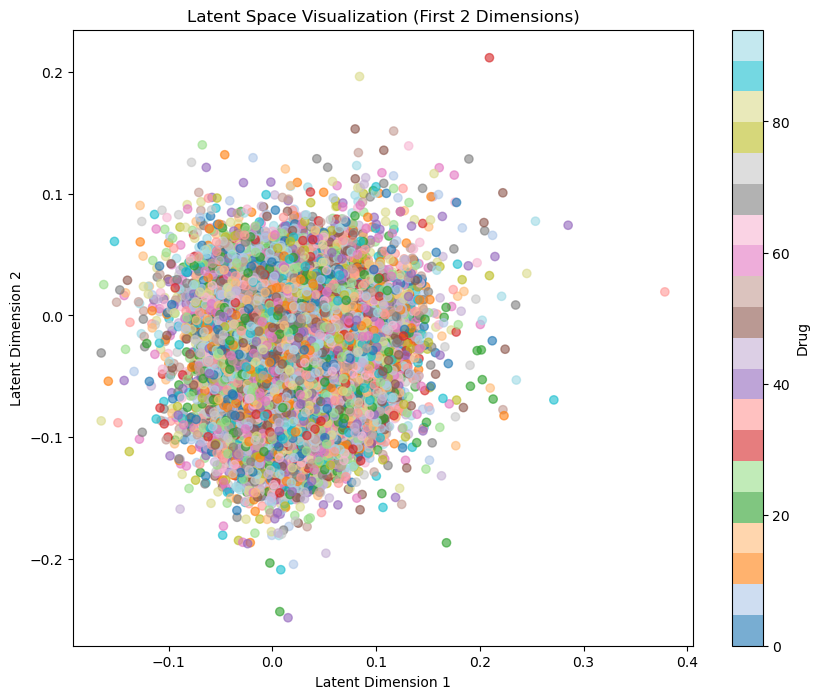

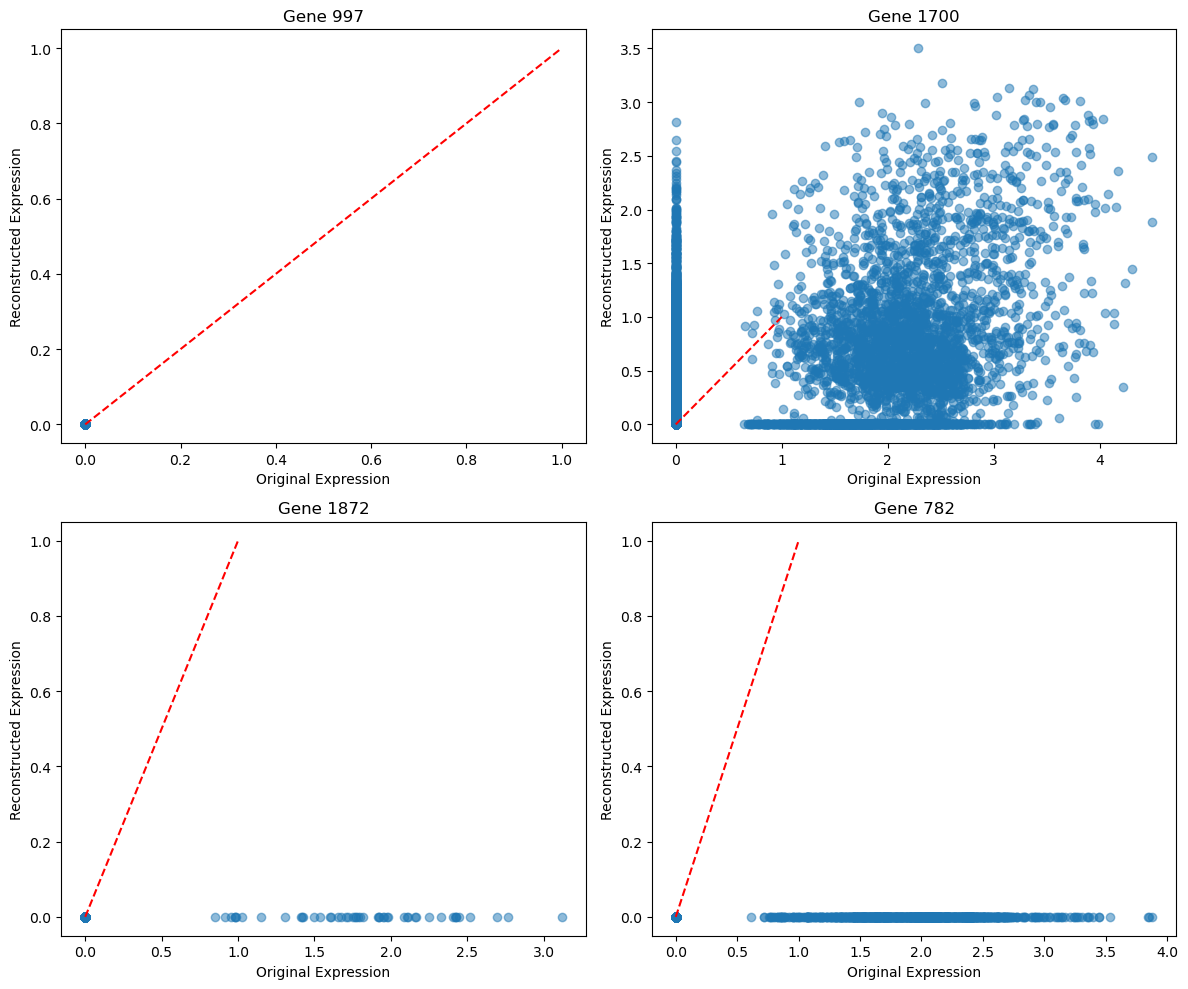

In [102]:


# Get the drug indices from the conditions
drug_indices = np.argmax(eval_results['conditions'][:, :len(adata_test.obs['drug'].unique())], axis=1)
drugs = adata_test.obs['drug'].unique()[drug_indices]

# Plot first two dimensions of latent space colored by drug
plt.figure(figsize=(10, 8))
scatter = plt.scatter(eval_results['latent'][:, 0], 
                     eval_results['latent'][:, 1], 
                     c=drug_indices, 
                     cmap='tab20',
                     alpha=0.6)
plt.title('Latent Space Visualization (First 2 Dimensions)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.colorbar(scatter, label='Drug')
plt.show()

# Plot reconstruction vs original for a few random genes
n_genes_to_plot = 4
random_genes = np.random.choice(eval_results['original'].shape[1], n_genes_to_plot, replace=False)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for idx, gene_idx in enumerate(random_genes):
    axes[idx].scatter(eval_results['original'][:, gene_idx], 
                     eval_results['recon'][:, gene_idx], 
                     alpha=0.5)
    axes[idx].plot([0, 1], [0, 1], 'r--')  # Diagonal line
    axes[idx].set_xlabel('Original Expression')
    axes[idx].set_ylabel('Reconstructed Expression')
    axes[idx].set_title(f'Gene {gene_idx}')

plt.tight_layout()
plt.show()